# NMX Demo
In this example, we will use simulated data from McStas v.3.4.

This is simulated data on a crystal of Rubredoxin, a small protein, using the "standard" conditions for NMX. <br>
| Parameter | Value | Notes |
|-----------|-------|-------|
| `wavelength_range` ($\mathring A$) | 1.8 - 3.55 | The planned range for standard NMX experiments |
| `protein_name` | Rubredoxin | Associated Common protein name |
| `unit_cell` | $a$ = 33.9 Å, $b$ = 34.9 Å, $c$ = 43.5 Å <br>  $\alpha$ = $\beta$ = $\gamma$ = 90° | Unit cell of rubredoxin |
| `space_group` | $P2_{1}2_{1}2_{1}$ (19) | Space group of rubredoxin

## Build Pipeline (Collect Parameters and Providers)
Import the providers from ``load_mcstas_nexus`` to use the ``McStas`` simulation data workflow. <br>
``MaximumProbability`` can be manually provided to derive more realistic number of events. <br>
It is because ``weights`` are given as probability, not number of events in a McStas file. <br>

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

from pathlib import Path
import h5py
import gemmi
from ess.nmx.mcstas import McStasWorkflow
import numpy as np

from ess.nmx.types import *
from ess.nmx.reduction import NMXData, NMXReducedData, merge_panels
from ess.nmx.nexus import export_as_nexus

In [13]:
datafiles = ["mccode_phi0.h5", "mccode_phi10.h5", "mccode_phi20.h5", "mccode_phi30.h5", "mccode_phi40.h5", "mccode_phi50.h5"]

In [2]:
from nmx_workflow.config import POOCH_DATA_DIR
# from nmx_workflow.dataset import download_datafiles
# download_datafiles([datafile])

# datafile_paths = [POOCH_DATA_DIR / datafile for datafile in datafiles]
# assert False not in [df.exists() for df in datafile_paths]

2025-02-21 10:11:27.136 | INFO     | nmx_workflow.config:<module>:11 - PROJ_ROOT path is: /Users/aaronfinke/nmx_workflow/nmx_workflow


In [15]:
wfs = [McStasWorkflow() for _ in range(5)]
wfs

In [16]:
for wf, datafile in zip(wfs, datafile_paths):
    # Replace with the path to your own file
    wf[FilePath] = datafile
    wf[MaximumProbability] = 10000
    wf[TimeBinSteps] = 50

NameError: name 'datafile_paths' is not defined

In [19]:
wfs[0]

We want to reduce all three panels, so we map the relevant part of the workflow over a list of the three panels:

In [17]:
# DetectorIndex selects what detector panels to include in the run
# in this case we select all three panels.
for wf in wfs:
    wf[NMXReducedData] = (
        wf[NMXReducedData]
        .map({DetectorIndex: sc.arange('panel', 3, unit=None)})
        .reduce(index="panel", func=merge_panels)
    )


## Build Workflow

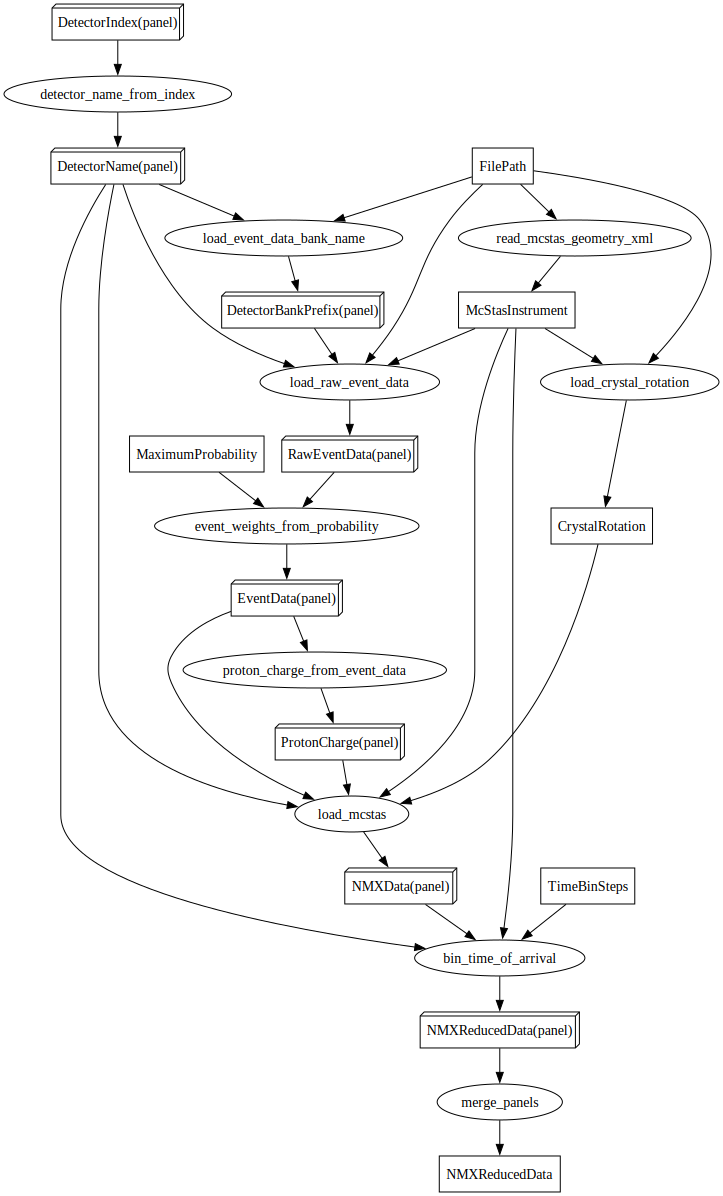

In [7]:
wf.visualize(NMXReducedData, graph_attr={"rankdir": "TD"}, compact=True)

## Compute Desired Types

In [11]:
from cyclebane.graph import NodeName, IndexValues

In [15]:
import tracemalloc

In [21]:
# Event data grouped by pixel id for each of the selected detectors
targets = [NodeName(NMXData, IndexValues(("panel",), (i,))) for i in range(3)]
dgs =[ merge_panels(*wf.compute(targets).values()) for wf in wfs ]


: 

In [10]:
# Data from all selected detectors binned by panel, pixel and timeslice
binned_dg = wf.compute(NMXReducedData)
binned_dg

DataGroup(sizes={'panel': 3, 'id': 1638400, 't': 50}, keys=[
    counts: DataArray({'panel': 3, 'id': 1638400, 't': 50}),
    proton_charge: Variable({'panel': 3}),
    crystal_rotation: Variable({}),
    fast_axis: Variable({'panel': 3}),
    slow_axis: Variable({'panel': 3}),
    origin_position: Variable({'panel': 3}),
    sample_position: Variable({}),
    source_position: Variable({}),
    sample_name: Variable({}),
    position: Variable({'panel': 3, 'id': 1638400}),
])

## Export Results

``NMXReducedData`` object has a method to export the data into nexus or h5 file.

You can save the result as ``test.nxs``, for example:


In [3]:
from nmx_workflow.config import PROCESSED_DATA_DIR

nexus_file = PROCESSED_DATA_DIR / "scipp_export.nxs"
#export_as_nexus(binned_dg, nexus_file)

2025-02-25 14:20:25.714 | INFO     | nmx_workflow.config:<module>:11 - PROJ_ROOT path is: /Users/aaronfinke/nmx_workflow/nmx_workflow


## Instrument View

Pixel positions are not used for later steps,
but it is included in the coordinates for instrument view.

All pixel positions are relative to the sample position,
therefore the sample is at (0, 0, 0).

**It might be very slow or not work in the ``VS Code`` jupyter notebook editor.**

In [12]:

import scippneutron as scn

da = dg["weights"]
da.coords["position"] = dg["position"]
# Plot one out of 100 pixels to reduce size of docs output
view = scn.instrument_view(da.hist(), pixel_size=0.0004, cbar=True)
view

Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(…

In [2]:
datafiles = ["mccode_phi0.h5", "mccode_phi10.h5", "mccode_phi20.h5", "mccode_phi30.h5", "mccode_phi40.h5", "mccode_phi50.h5"]

from nmx_workflow.config import POOCH_DATA_DIR
from nmx_workflow.config import PROCESSED_DATA_DIR

# from nmx_workflow.dataset import download_datafiles
# download_datafiles([datafile])

datafile_paths = [POOCH_DATA_DIR / datafile for datafile in datafiles]
assert False not in [df.exists() for df in datafile_paths]

2025-02-13 10:39:11.809 | INFO     | nmx_workflow.config:<module>:11 - PROJ_ROOT path is: /Users/aaronfinke/nmx_workflow/nmx_workflow


In [5]:
from nmx_workflow.config import PROCESSED_DATA_DIR
from cyclebane.graph import NodeName, IndexValues
import gc

for datafile_path in datafile_paths:
    print(f"Processing file {str(datafile_path)}...")
    wf = McStasWorkflow()
    wf[FilePath] = datafile_path
    wf[MaximumProbability] = 10000
    wf[TimeBinSteps] = 50
    wf[NMXReducedData] = (
            wf[NMXReducedData]
            .map({DetectorIndex: sc.arange('panel', 3, unit=None)})
            .reduce(index="panel", func=merge_panels)
        )
    targets = [NodeName(NMXData, IndexValues(("panel",), (i,))) for i in range(3)]
    dg = merge_panels(*wf.compute(targets).values())
    binned_dg = wf.compute(NMXReducedData)

    with h5py.File(datafile_path) as fp:
        phi = fp['entry1/simulation/Param/XtalPhiY'][...]
    phi = int(phi[0])

    nexus_file = PROCESSED_DATA_DIR / f"scipp_export_phi{phi}.nxs"
    export_as_nexus(binned_dg, nexus_file)

    with h5py.File(nexus_file,'r+') as fp:
        det_data = fp['NMX_data']['NXinstrument']['detector_1']
        fp['NMX_data']['detector_1'] =  det_data
        del fp['NMX_data']['NXinstrument']['detector_1']
    wf = None
    dg = None
    binned_dg = None
    gc.collect()

    


Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi0.h5...
Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi10.h5...
Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi20.h5...
Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi30.h5...
Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi40.h5...
Processing file /Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi50.h5...


In [3]:
import glob
from nmx_workflow.config import PROCESSED_DATA_DIR
output_paths = glob.glob(f"{PROCESSED_DATA_DIR}/scipp_export*")
output_paths

2025-02-25 15:18:47.675 | INFO     | nmx_workflow.config:<module>:11 - PROJ_ROOT path is: /Users/aaronfinke/nmx_workflow/nmx_workflow


['/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi30.nxs',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi20.nxs',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi50.nxs',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi0.nxs',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi40.nxs',
 '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/processed/scipp_export_phi10.nxs']

The below is a quick workaround for current DIALS install, will be fixed in DIALS later.

## Data Reduction with DIALS

DIALS will be used for spotfinding, indexing, integration.

In [19]:
from libtbx.phil import parse

from dials.command_line import dials_import
from dials.command_line import find_spots
from dials.command_line import index
from dials.command_line import refine
from dials.command_line import tof_integrate

from dials.util import log

from dials.array_family.flex import reflection_table
from dxtbx.model.experiment_list import ExperimentListFactory

from libtbx.phil import parse

In [5]:
dials_directory = PROCESSED_DATA_DIR / "dials"
dials_directory.mkdir(exist_ok=True)

## Importing Data into DIALS

DIALS uses PHIL (Python-based hierarchical interchange language), a JSON-like format for setting and organizing parameters for each processing module.

In [6]:
phil_scope = dials_import.phil_scope
format_phil = parse(f"""
output {{
    experiments = '{dials_directory}/imported.expt'
    log = '{dials_directory}/dials.import.log'
    compact = False
}}
""")
# working_phil = phil_scope.fetch(
#     sources = [format_phil])
# x = working_phil.format(python_object=None)
arg_hil = []
for x in format_phil.all_definitions():
    arg_hil.append(x.path + '=' + x.object.words[0].value)


In [7]:
log.config(verbosity=0,logfile=f"{dials_directory}/dials.import.log")
experiments = dials_import.do_import(args=[str(nexus_file) for nexus_file in output_paths] + arg_hil, phil=phil_scope, configure_logging=True);

100%|██████████| 6/6 [00:00<00:00, 110.28it/s]


## Spot Finding

Spotfinding looks for spots on images separated by time bins.

In [11]:
findSpots = parse(f"""
output {{
    reflections = '{dials_directory}/strong.refl'
    log = '{dials_directory}/dials.find_spots.log'
}}
spotfinder {{
threshold {{
   dispersion {{
     gain = 0.0013
     kernel_size = 15 15
     sigma_background = 5
     sigma_strong = 3
     min_local = 2
	}}
     algorithm=radial_profile

}}
filter {{
   min_spot_size = 30
   max_spot_size = 9000

}}
}}
""")

working_phil = find_spots.working_phil

findSpots_phil = working_phil.fetch(
    sources=[findSpots])

findSpots_params = findSpots_phil.extract()

with open(dials_directory/'find_spots.phil','w') as fp:
    findSpots_phil.show(out=fp)

In [12]:
log.config(verbosity=0,logfile=findSpots_params.output.log)
reflections = find_spots.do_spotfinding(experiments=experiments, params=findSpots_params)


## Indexing in DIALS

In [13]:
index_phil = index.phil_scope
unit_cell = [33.41,34.75,43.65,90,90,90]
space_group = 'P212121'

index_options = parse(
f"""output {{
    reflections = '{dials_directory}/indexed.refl'
    experiments = '{dials_directory}/indexed.expt'
    log = '{dials_directory}/dials.index.log'
}}

indexing {{
  known_symmetry {{
    space_group = "{space_group}"
    unit_cell = {",".join(str(x) for x in unit_cell)}
  }}
}}
""")

index_params = index_phil.fetch(
    sources=[index_options]).extract()

In [14]:
log.config(verbosity=0, logfile=index_params.output.log)
indexed_experiments, indexed_reflections = index.index(
    experiments=experiments,
    reflections=[reflections],
    params=index_params)


## Refinement 
Refine the diffraction geometry against indexed reflections

In [25]:
refinement_phil = refine.phil_scope

refine_options = parse(
f"""
output {{
    experiments = {dials_directory}/refined.expt
    reflections = {dials_directory}/refined.refl
    log = {dials_directory}/dials.refine.log
}}
detector {{
    panels = hierarchical
}}
"""
)

refine_params = refinement_phil.fetch(
    sources=[refine_options]).extract()

In [26]:
log.config(verbosity=0, logfile=refine_params.output.log)
refined_experiments, refined_reflections, refiner, refine_history = refine.run_dials_refine(
    indexed_experiments, indexed_reflections, refine_params)

## Integrating TOF Data

In [32]:
dmin = None

integration_phil = tof_integrate.phil_scope

integration_options = parse(
f"""
output {{
    experiments = {dials_directory}/integrated.expt
    reflections = {dials_directory}/integrated.refl
    log = {dials_directory}/dials.tof_integrate.log
}}
integration_type = *observed calculated

calculated{{
    dmin = {dmin if dmin else 'none'}
}}
method = *summation seed_skewness profile1d
"""
)

integration_params = integration_phil.fetch(
    sources=[integration_options]).extract()

In [33]:
integrated_reflections = tof_integrate.run_integrate(integration_params,refined_experiments,refined_reflections)
integrated_reflections.as_msgpack_file(integration_params.output.reflections)
refined_experiments.as_file(integration_params.output.experiments)

dmin 1.04437263169572


Getting shoebox data
Computing for experiment 0
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x304a12ab0>
Computing for experiment 1
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x304a12ea0>
Computing for experiment 2
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x304a12c00>
Computing for experiment 3
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x304a126c0>
Computing for experiment 4
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x306144040>
Computing for experiment 5
  Calculating summed intensities for expt <dxtbx_model_ext.Experiment object at 0x306144120>


In [79]:
def get_unit_cell_from_real_space(experiment) -> tuple:
    """
    Get the unit cell from real-space parameters from
    the DIALS experiment file.
    """
    from dxtbx.model import ExperimentList
    if isinstance(experiment,ExperimentList):
        experiment = experiment[0]

    rs_a = experiment['crystal'][0]['real_space_a']
    rs_b = experiment['crystal'][0]['real_space_b']
    rs_c = experiment['crystal'][0]['real_space_c']
    mag_a = np.linalg.norm(rs_a)
    mag_b = np.linalg.norm(rs_b)
    mag_c = np.linalg.norm(rs_c)
    al = np.degrees(np.arccos(np.dot(rs_b,rs_c)/(mag_b*mag_c)))
    be = np.degrees(np.arccos(np.dot(rs_a,rs_c)/(mag_a*mag_c)))
    ga = np.degrees(np.arccos(np.dot(rs_b,rs_a)/(mag_b*mag_a)))
    return (mag_a,mag_b,mag_c,al,be,ga)

def get_unit_cell(experiment) -> tuple[float]:
    from dxtbx.model import ExperimentList
    if isinstance(experiment,ExperimentList):
        experiment = experiment[0]

    uc = experiment.crystal.get_unit_cell()
    return uc.parameters()

In [ ]:
def get_spacegroup(experiment) -> tuple[str,int]:
    """
    Get spacegroup from experiment file.
    A bit roundabout way to do it.
    """
    from dxtbx.model import ExperimentList
    if isinstance(experiment,ExperimentList):
        experiment = experiment[0]
    sg = experiment.crystal.get_space_group()
    sg_info = sg.info().symbol_and_number().split('(')
    num = int(''.join(filter(str.isdigit, sg_info[1])))
    sgstr = sg_info[0].rstrip()
    return sgstr,num

In [80]:
get_spacegroup(refined_experiments)
get_unit_cell(refined_experiments)

(34.741638082128595, 35.80710864687599, 44.56594505425292, 90.0, 90.0, 90.0)

In [17]:
def get_asu(row):
    return asu.to_asu(row['hkl'],space_group.operations())[0]

In [79]:
from scipy.optimize import minimize
import copy

# Remove points w. zero sigma
df = copy.deepcopy(df[df['I'] > 0])

"""
Normalized wavelength, Eq. 11

Arguments:
    wavelength: wavelength
    min_wavelength: minimum wavelength
    max_wavelength: maximum wavelength
"""
def l_norm(l, l_min, l_max):
    return (2*l - l_max - l_min) / (l_max - l_min)
    #return np.polynomial.chebyshev.Chebyshev(poly_coeffs)(wavelength_prime)

"""
Function to minimize, variations of Eq. 2

Parameters:
    poly_coeffs: array of length `n_ord` (LSCALE terminology)
"""
def target_func(poly_coeffs):
    l_ref = df.LAMBDA.mean()
    l_min = df.LAMBDA.min()
    l_max = df.LAMBDA.max()
    chebyshev = np.polynomial.chebyshev.Chebyshev(poly_coeffs)
    reference = chebyshev(l_norm(l_ref, l_min, l_max))
    df["fL"] = df.LAMBDA.apply(lambda l: chebyshev(l_norm(l, l_min, l_max)) ) / reference
    df["f_tot"] = df.fL #* df.fLorentz * df.fP * df.fob
    return (((df.f_tot * df.I - df.I.mean()) / (df.SIGI * df.f_tot))**2).sum()

# poly_coeffs = np.array([7.947e+05, -3.875e+05, -4.088e+05])
poly_coeffs = np.array([1,1,1,1,1,1,1])

fit = minimize(target_func, poly_coeffs, method='SLSQP', tol=1e-3)
print(fit)
# df.plot(x='wavelength', y='fL', kind='scatter')

 message: Iteration limit reached
 success: False
  status: 9
     fun: 88928630379.9337
       x: [-6.875e+12  5.335e+12 -1.787e+12 -2.029e+12  4.945e+12
           -6.836e+12  7.197e+12]
     nit: 100
     jac: [ 2.339e-02  4.849e-02  1.084e-02 -2.464e-02  4.775e-02
            1.874e-02 -2.975e-02]
    nfev: 830
    njev: 100


In [77]:
df.LAMBDA.min()

1.8445288356777902

In [ ]:
%load_ext autoreload
%autoreload 2

from ess.nmx.mcstas import McStasMetadataWorkflow
from ess.nmx.mcstas.load import NMXMetadata

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
mdwf = McStasMetadataWorkflow()

mdwf[FilePath] = '/Users/aaronfinke/nmx_workflow/nmx_workflow/data/raw/main/mccode_phi0.h5'

In [23]:
mdwf[NMXMetadata] = (
    mdwf[NMXMetadata]
    .map({DetectorIndex: sc.arange('panel', 3, unit=None)})
    .reduce(index="panel", func=merge_panels)
)


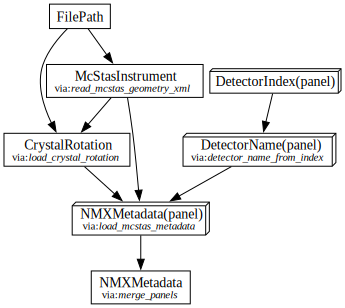

In [24]:
mdwf.visualize(NMXMetadata, graph_attr={"rankdir": "TD"}, compact=True)

In [25]:
nmxmetadata = mdwf.compute(NMXMetadata)
nmxmetadata

DataGroup(sizes={'panel': 3, 'id': 1638400}, keys=[
    crystal_rotation: Variable({}),
    fast_axis: Variable({'panel': 3}),
    slow_axis: Variable({'panel': 3}),
    origin_position: Variable({'panel': 3}),
    sample_position: Variable({}),
    source_position: Variable({}),
    sample_name: Variable({}),
    position: Variable({'panel': 3, 'id': 1638400}),
])

In [70]:
sg = refined_experiments[0].crystal.get_space_group()
sg_info = sg.info().symbol_and_number().split('(')
num = int(''.join(filter(str.isdigit, sg_info[1])))
sgstr = sg_info[0].rstrip()
(sgstr,num)

('P 21 21 21', 19)

In [76]:
uc = refined_experiments[0].crystal.get_unit_cell()
uc.parameters()

(34.741638082128595, 35.80710864687599, 44.56594505425292, 90.0, 90.0, 90.0)